# 모듈

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.model_selection import GridSearchCV

# 파일 읽기

In [72]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


In [73]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [74]:
y = data['price'] # Target Label
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

In [75]:
del data['price'] # 훈련 데이터 내 Traget Label 삭제

print(data.columns)
print(len(data.columns))

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
20


In [76]:
len(data)

15035

In [77]:
len(sub)

6468

In [78]:
len(data) + len(sub)

21503

In [79]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [80]:
data.tail()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15030,15030,20141014T000000,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,15031,20150326T000000,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,15032,20140521T000000,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,15033,20150223T000000,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
15034,15034,20141015T000000,2,0.75,1020,1076,2.0,0,0,3,7,1020,0,2008,0,98144,47.5941,-122.299,1020,1357


In [81]:
sub.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [82]:
sub.tail()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
6463,21498,20140626T000000,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,21499,20150126T000000,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,21500,20150219T000000,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,21501,20140623T000000,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
6467,21502,20150116T000000,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [83]:
data.shape

(15035, 20)

In [84]:
sub.shape

(6468, 20)

In [85]:
train_len = len(data)
# train 데이터(price 정보 제외)와 test데이터 합침
data = pd.concat((data, sub), axis=0)  # (15035,20) 와 (6468,20)을 shape[0]기준으로 합친다

print(len(data))

21503


In [86]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


# 결측치 확인

<AxesSubplot:>

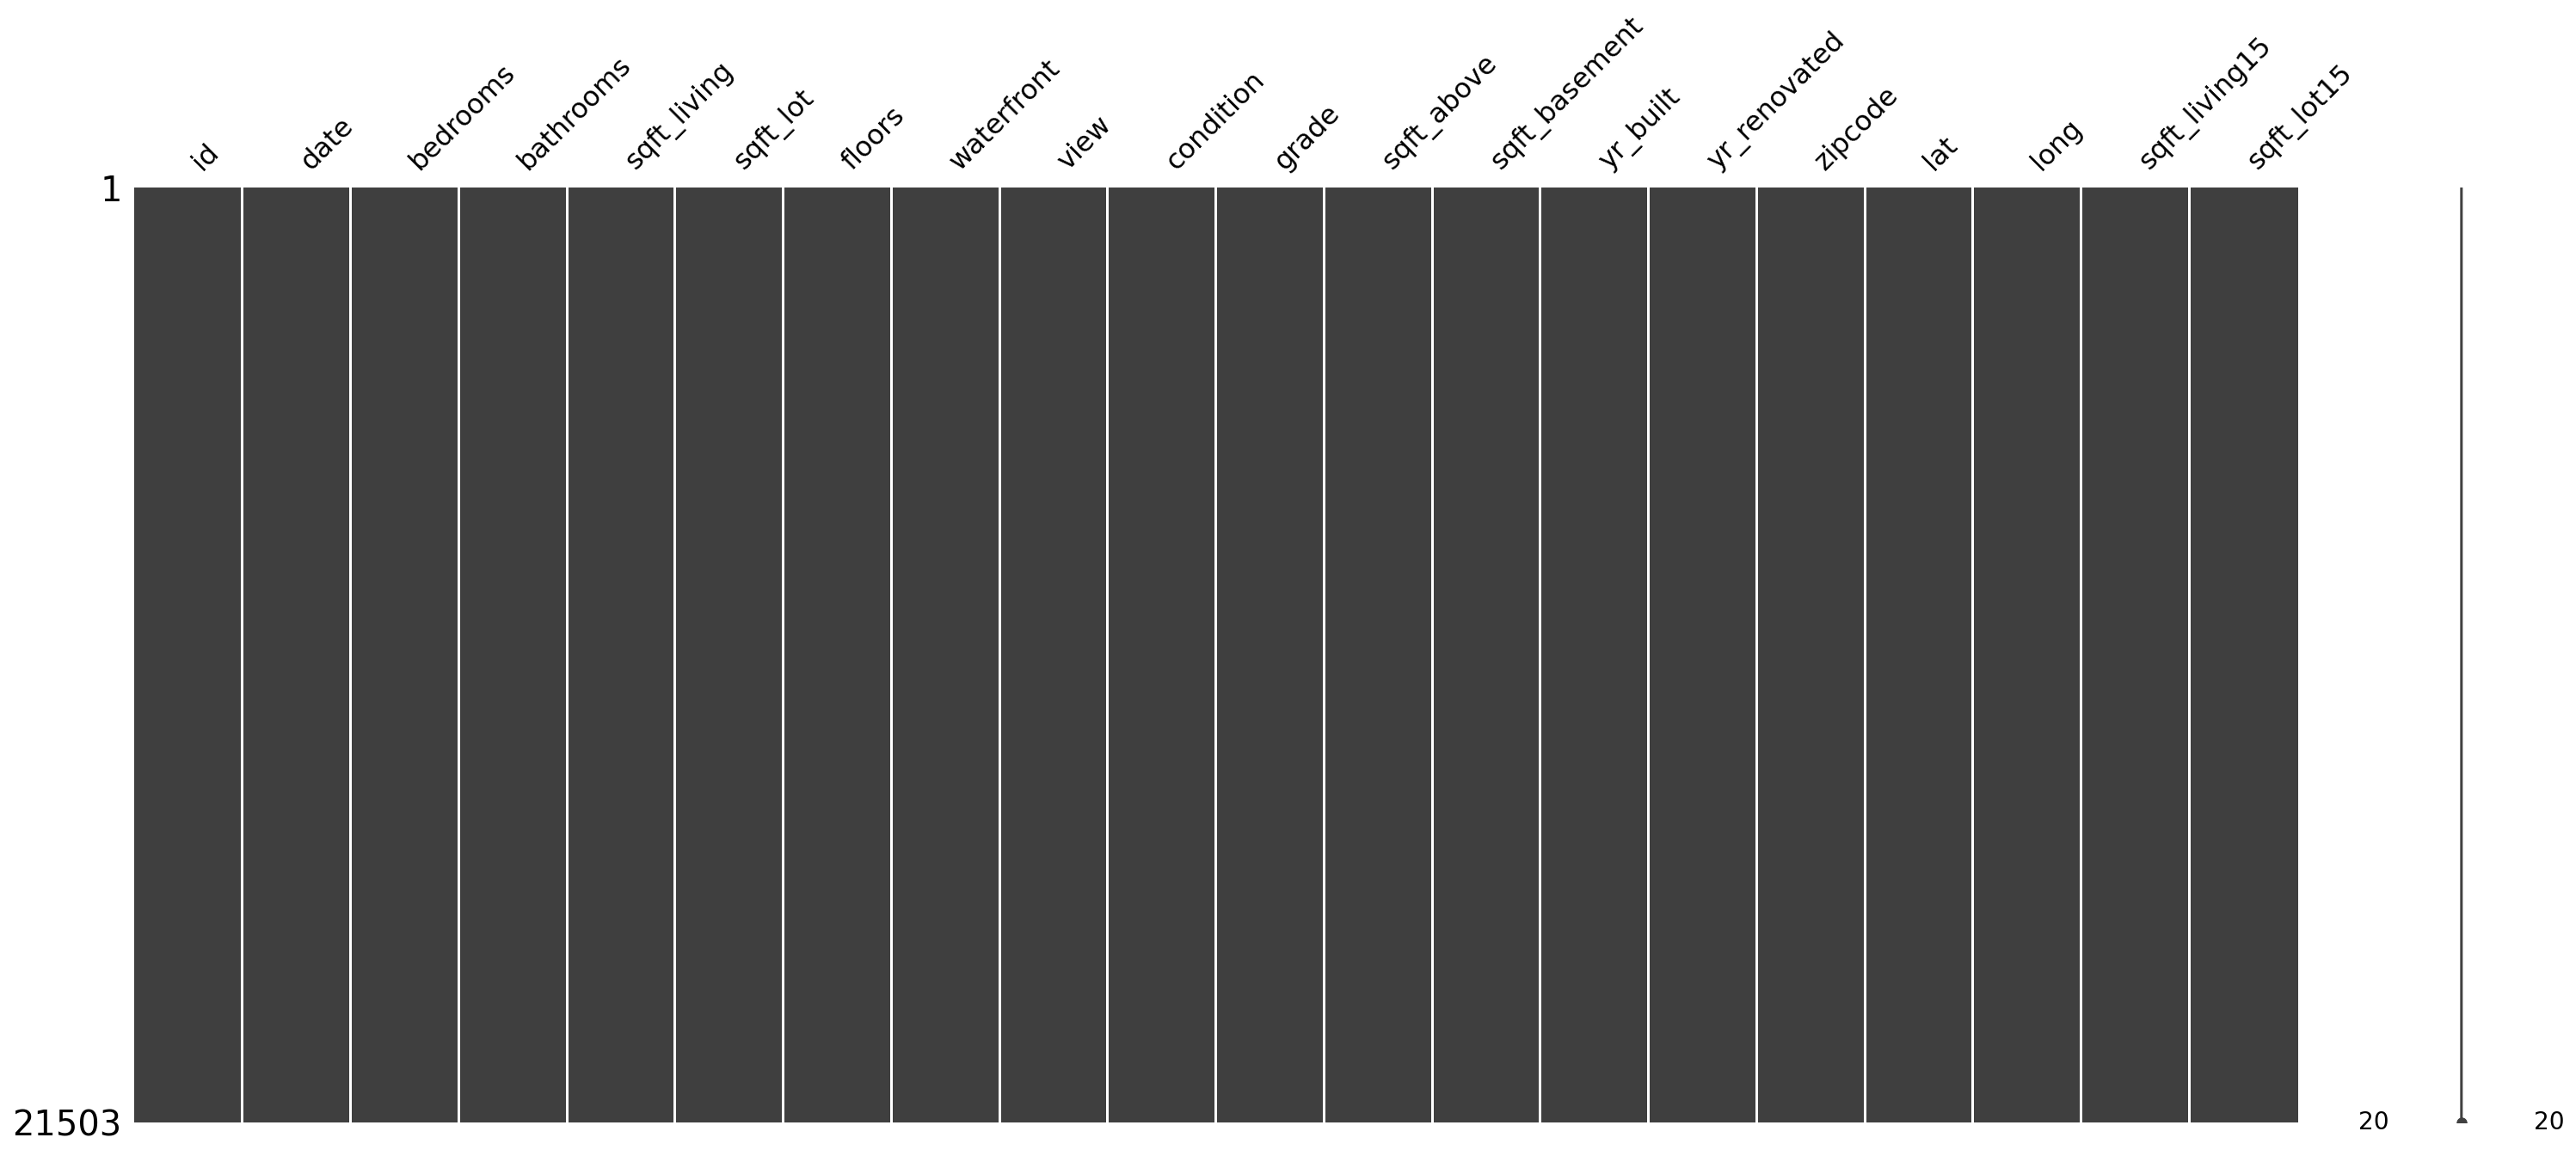

In [87]:
msno.matrix(data)

In [88]:
# DataFrame.loc[행 인덱싱값, 열 인덱싱값]
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values))) # pd.isnull(data[c]) -> return : Series 타입

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


# 데이터 Preprocessing

###### id

In [89]:
# 'id' : 집을 구분하는 번호 
data['id']

0           0
1           1
2           2
3           3
4           4
        ...  
6463    21498
6464    21499
6465    21500
6466    21501
6467    21502
Name: id, Length: 21503, dtype: int64

In [90]:
len(data)

21503

In [91]:
sorted(data.index)[-5:]

[15030, 15031, 15032, 15033, 15034]

In [92]:
# DataFrame의 index가 중복된 경우가 존재한다
data[data.index.value_counts()>1]

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,21498,20140626T000000,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,21499,20150126T000000,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,21500,20150219T000000,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,21501,20140623T000000,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007


In [93]:
# 중복된 'id'는 존재하지 않는다
data[data['id'].value_counts()>2]

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


In [94]:
id_indexed = data.set_index(keys = 'id', inplace = False)
id_indexed.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,
0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [97]:
reset_indexed = data.reset_index(drop = True)
reset_indexed.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [98]:
reset_indexed.tail()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
21498,21498,20140626T000000,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
21499,21499,20150126T000000,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
21500,21500,20150219T000000,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
21501,21501,20140623T000000,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21502,21502,20150116T000000,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [99]:
data = reset_indexed
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [100]:
train_len

15035

In [101]:
data['id'][train_len:]

15035    15035
15036    15036
15037    15037
15038    15038
15039    15039
         ...  
21498    21498
21499    21499
21500    21500
21501    21501
21502    21502
Name: id, Length: 6468, dtype: int64

In [102]:
data['id']

0            0
1            1
2            2
3            3
4            4
         ...  
21498    21498
21499    21499
21500    21500
21501    21501
21502    21502
Name: id, Length: 21503, dtype: int64

In [103]:
sub_id = data['id'][train_len:] # test 데이터셋에 해당하는 id 정보
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [104]:
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [105]:
data['date'] = data['date'].apply(lambda x : str(x[:6])) # date : YYYYDD로 변경

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [106]:
len(data.columns)

19

In [107]:
data.columns

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

# 데이터 분포 시각화

###### KDE의 개념 (Feat. Gaussian Kernel)

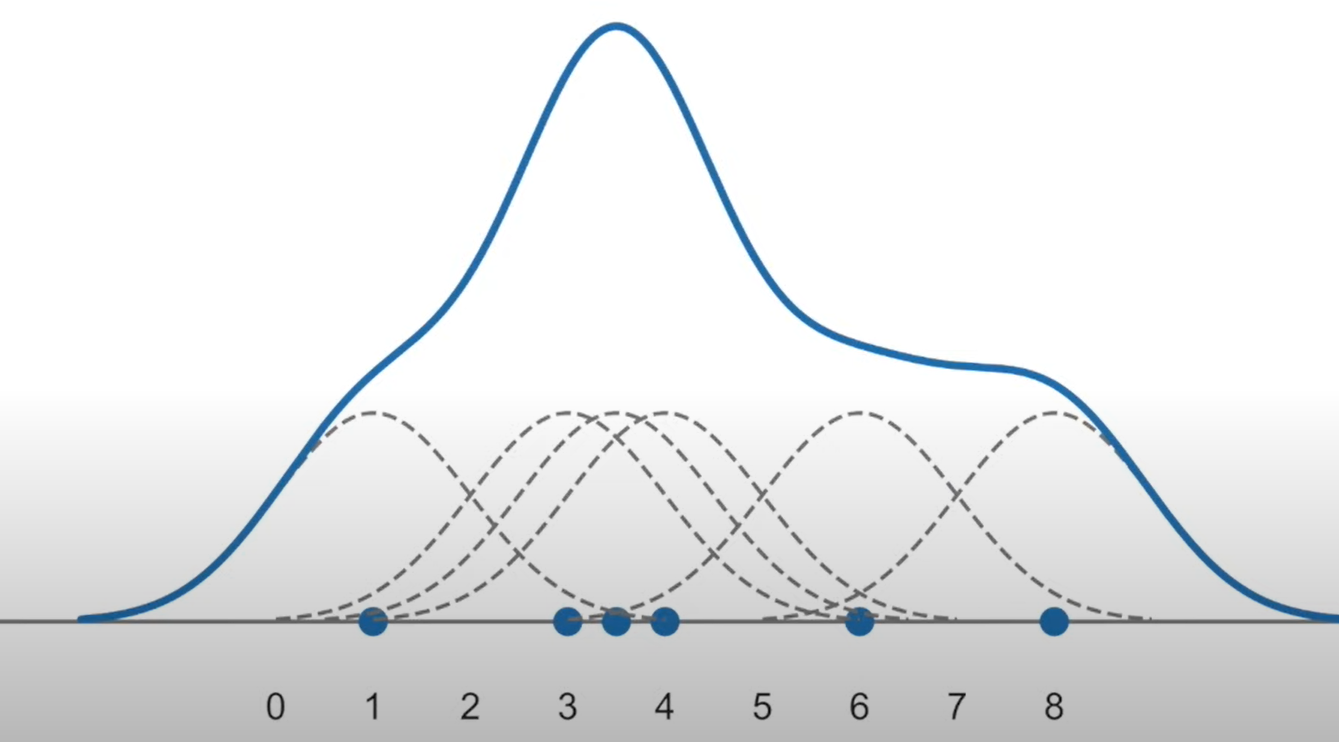

###### PDF

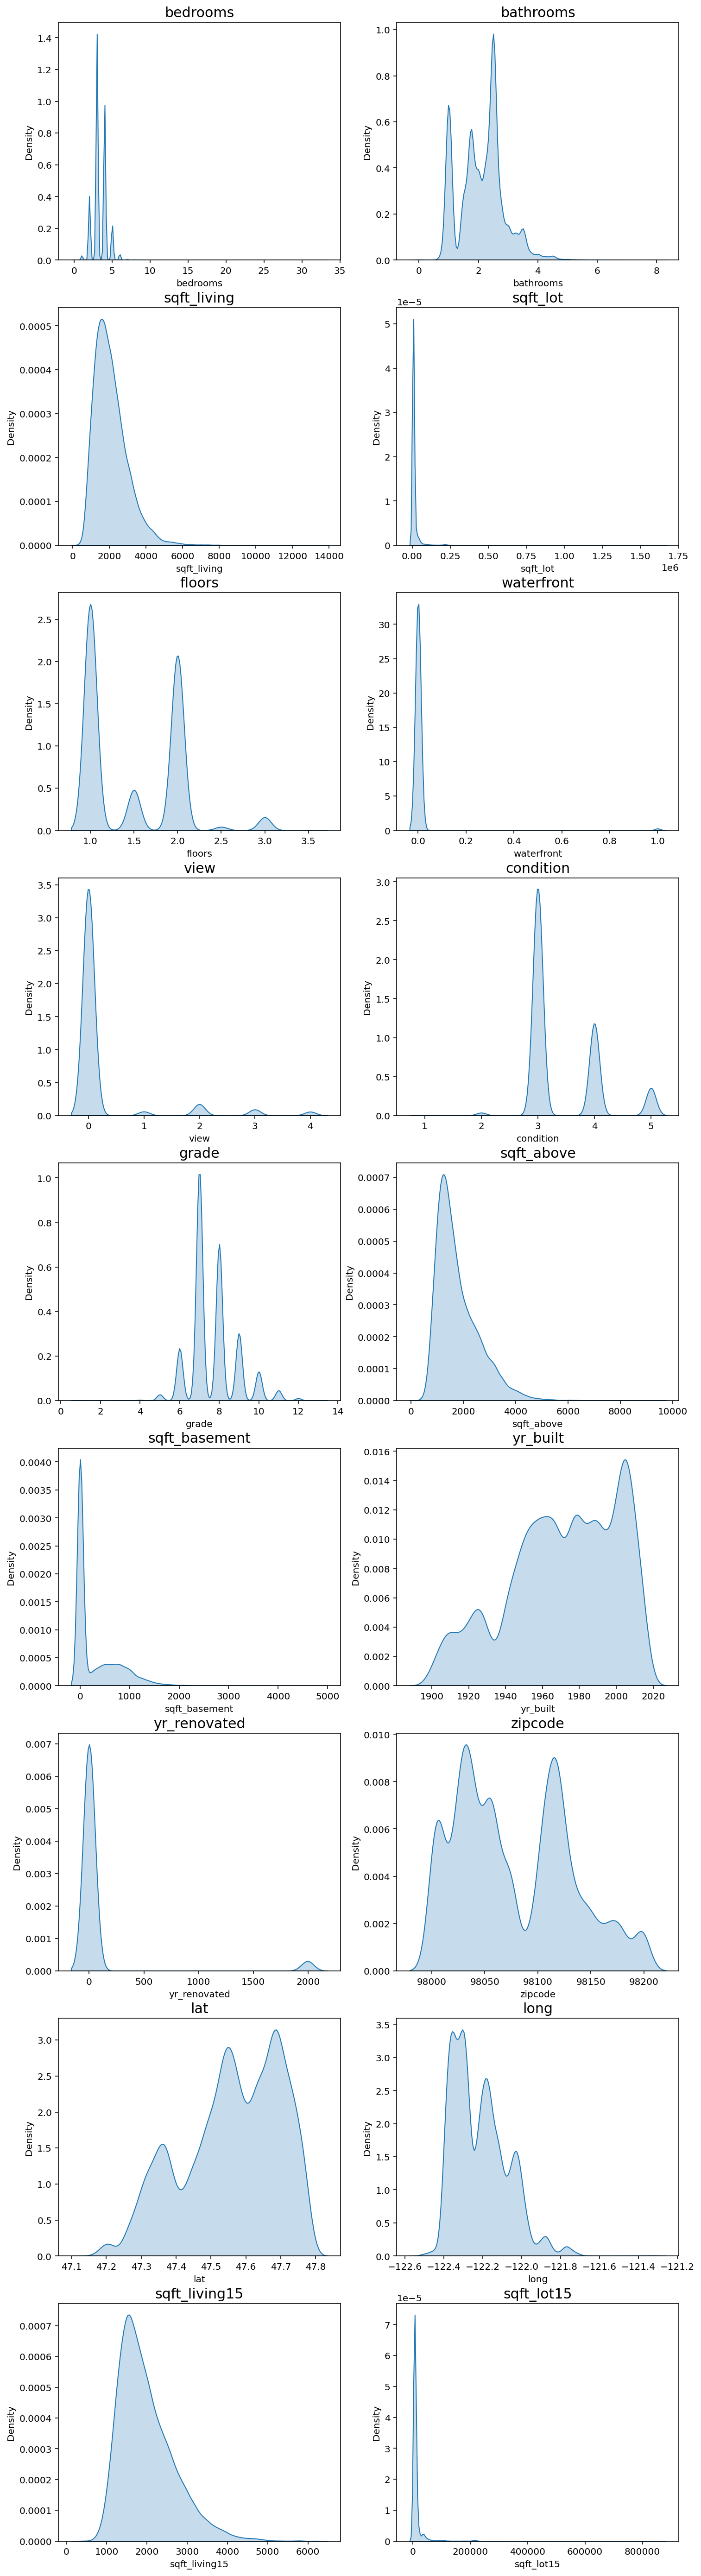

In [112]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

count = 1 # data 칼럼 제외하고 plot 그리기
columns = data.columns
for row in range(ax.shape[0]):
    for col in range(ax.shape[1]):
        sns.kdeplot(data[columns[count]], shade = True, ax=ax[row][col]) # Kernel Density Estimation : smoothed version of histogram
        # kdeplot 사용시 bw값을 올리면, 더 smooth한 그래프를 얻을 수 있지만
        # 반대급부로, 최빈값(mode)을 잃을 수 있다. 
        # bw를 계산하는 방식 ('bw_method')에는 2가지가 있다. 
        # 1. Scott 
        # 2. Silverman
        
        # 누적분포함수 CDF
        #sns.kdeplot(data[columns[count]], shade = True, cumulative= True, ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

###### cf. 2차원 KDE Plot 

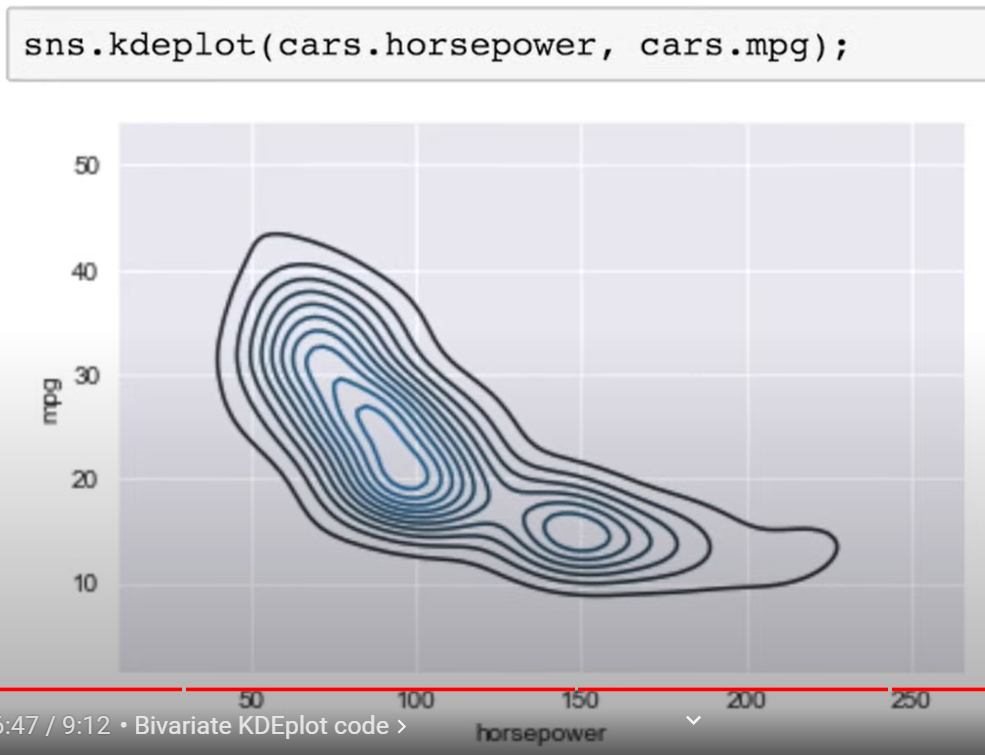

n_levels 인자를 통해, 더 세세한 구분도 가능하다 <br/>
n_levels 인자를 키우면, 등고선의 개수가 증가

# 시각화를 통해, 치우친 데이터 Column Nomalization

###### log1p Normalization

거리(distances), 횟수(times), 돈(money) 같은 양수 값들은 
right skewed의 모양을 가질 가능성이 높다

1. right skewed
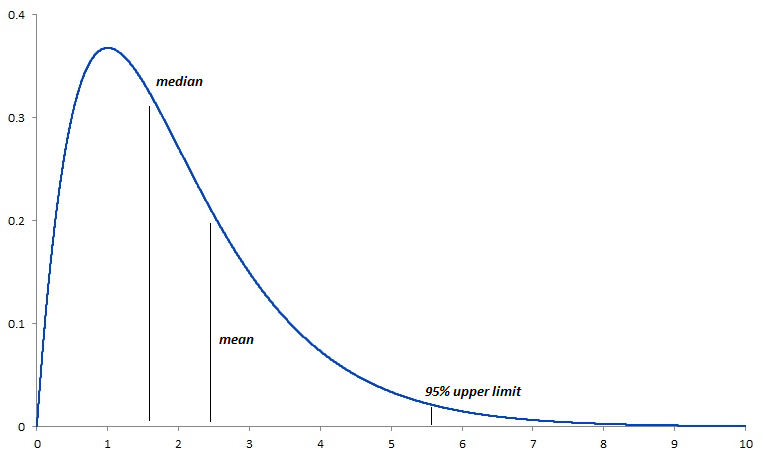

2. left skewed 

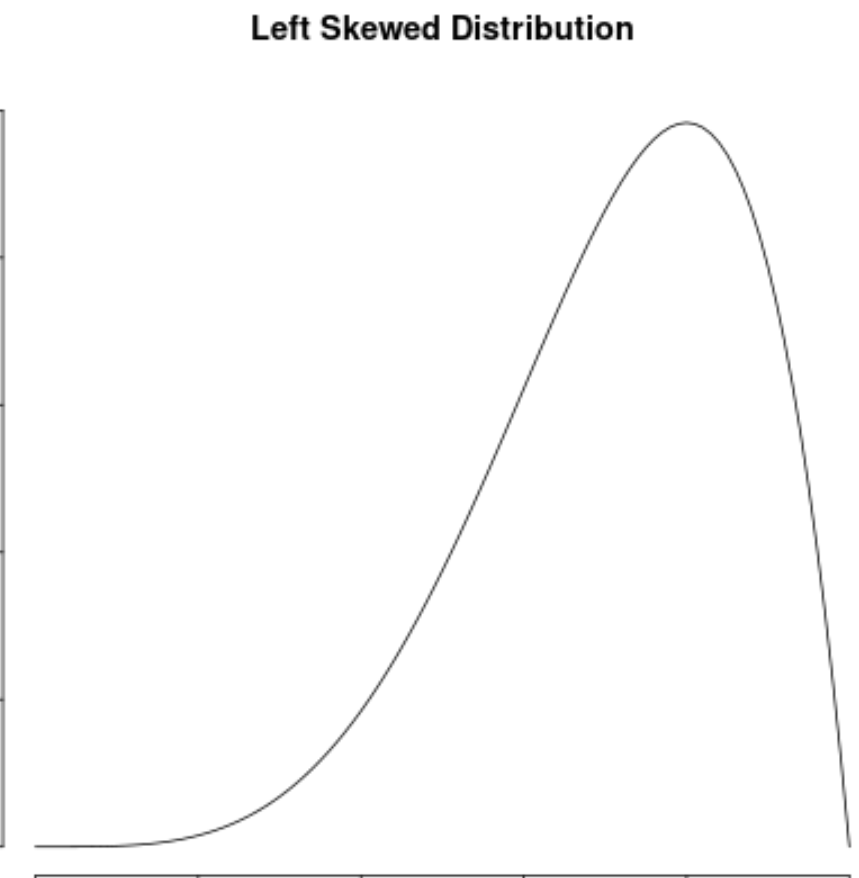

이때(Right Skewed),<br/> 
log Transformation을 사용하면 큰 값들은 더욱 Squashed down(압축되고), 작은 값들은 덜 Squashed down되어, <br/>
결과적으로 좌우대칭적이고, 정규분포(Normal)에 가까운 분포를 얻을 수 있다. 

 이것의 장점은 Right Skewed 형태일 때, 평균값(mean)과 중앙값(median)사이에 상당한 격차를 보인다, <br/>
 하지만, log Transformation을 통해 얻은 정규분포에 가까운 좌우대칭(symmetric)의 분포는 평균값과 중앙값이 상당히 가까운 거리에 위치하게 된다

###### cf. Feature Transformation and Scaling Techniques 
https://www.analyticsvidhya.com/blog/2020/07/types-of-feature-transformation-and-scaling/

In [114]:
# 값들이 치우친 Column들 
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values) # 로그를 통해 Nomalization 진행

print('얍💢')

얍💢


In [115]:
type(data)

pandas.core.frame.DataFrame

In [116]:
data.shape

(21503, 19)

In [117]:
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,0,98178,47.5112,-122.257,7.201171,8.639588
1,201502,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,0,98028,47.7379,-122.233,7.908755,8.995041
2,201502,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,0,98074,47.6168,-122.045,7.496097,8.923191
3,201406,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,0,98003,47.3097,-122.327,7.713785,8.827615
4,201501,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,0,98198,47.4095,-122.315,7.409136,9.181118


In [118]:
type(skew_columns)

list

In [119]:
skew_columns

['bedrooms',
 'sqft_living',
 'sqft_lot',
 'sqft_above',
 'sqft_basement',
 'sqft_lot15',
 'sqft_living15']

# Log Nomalization 결과 확인

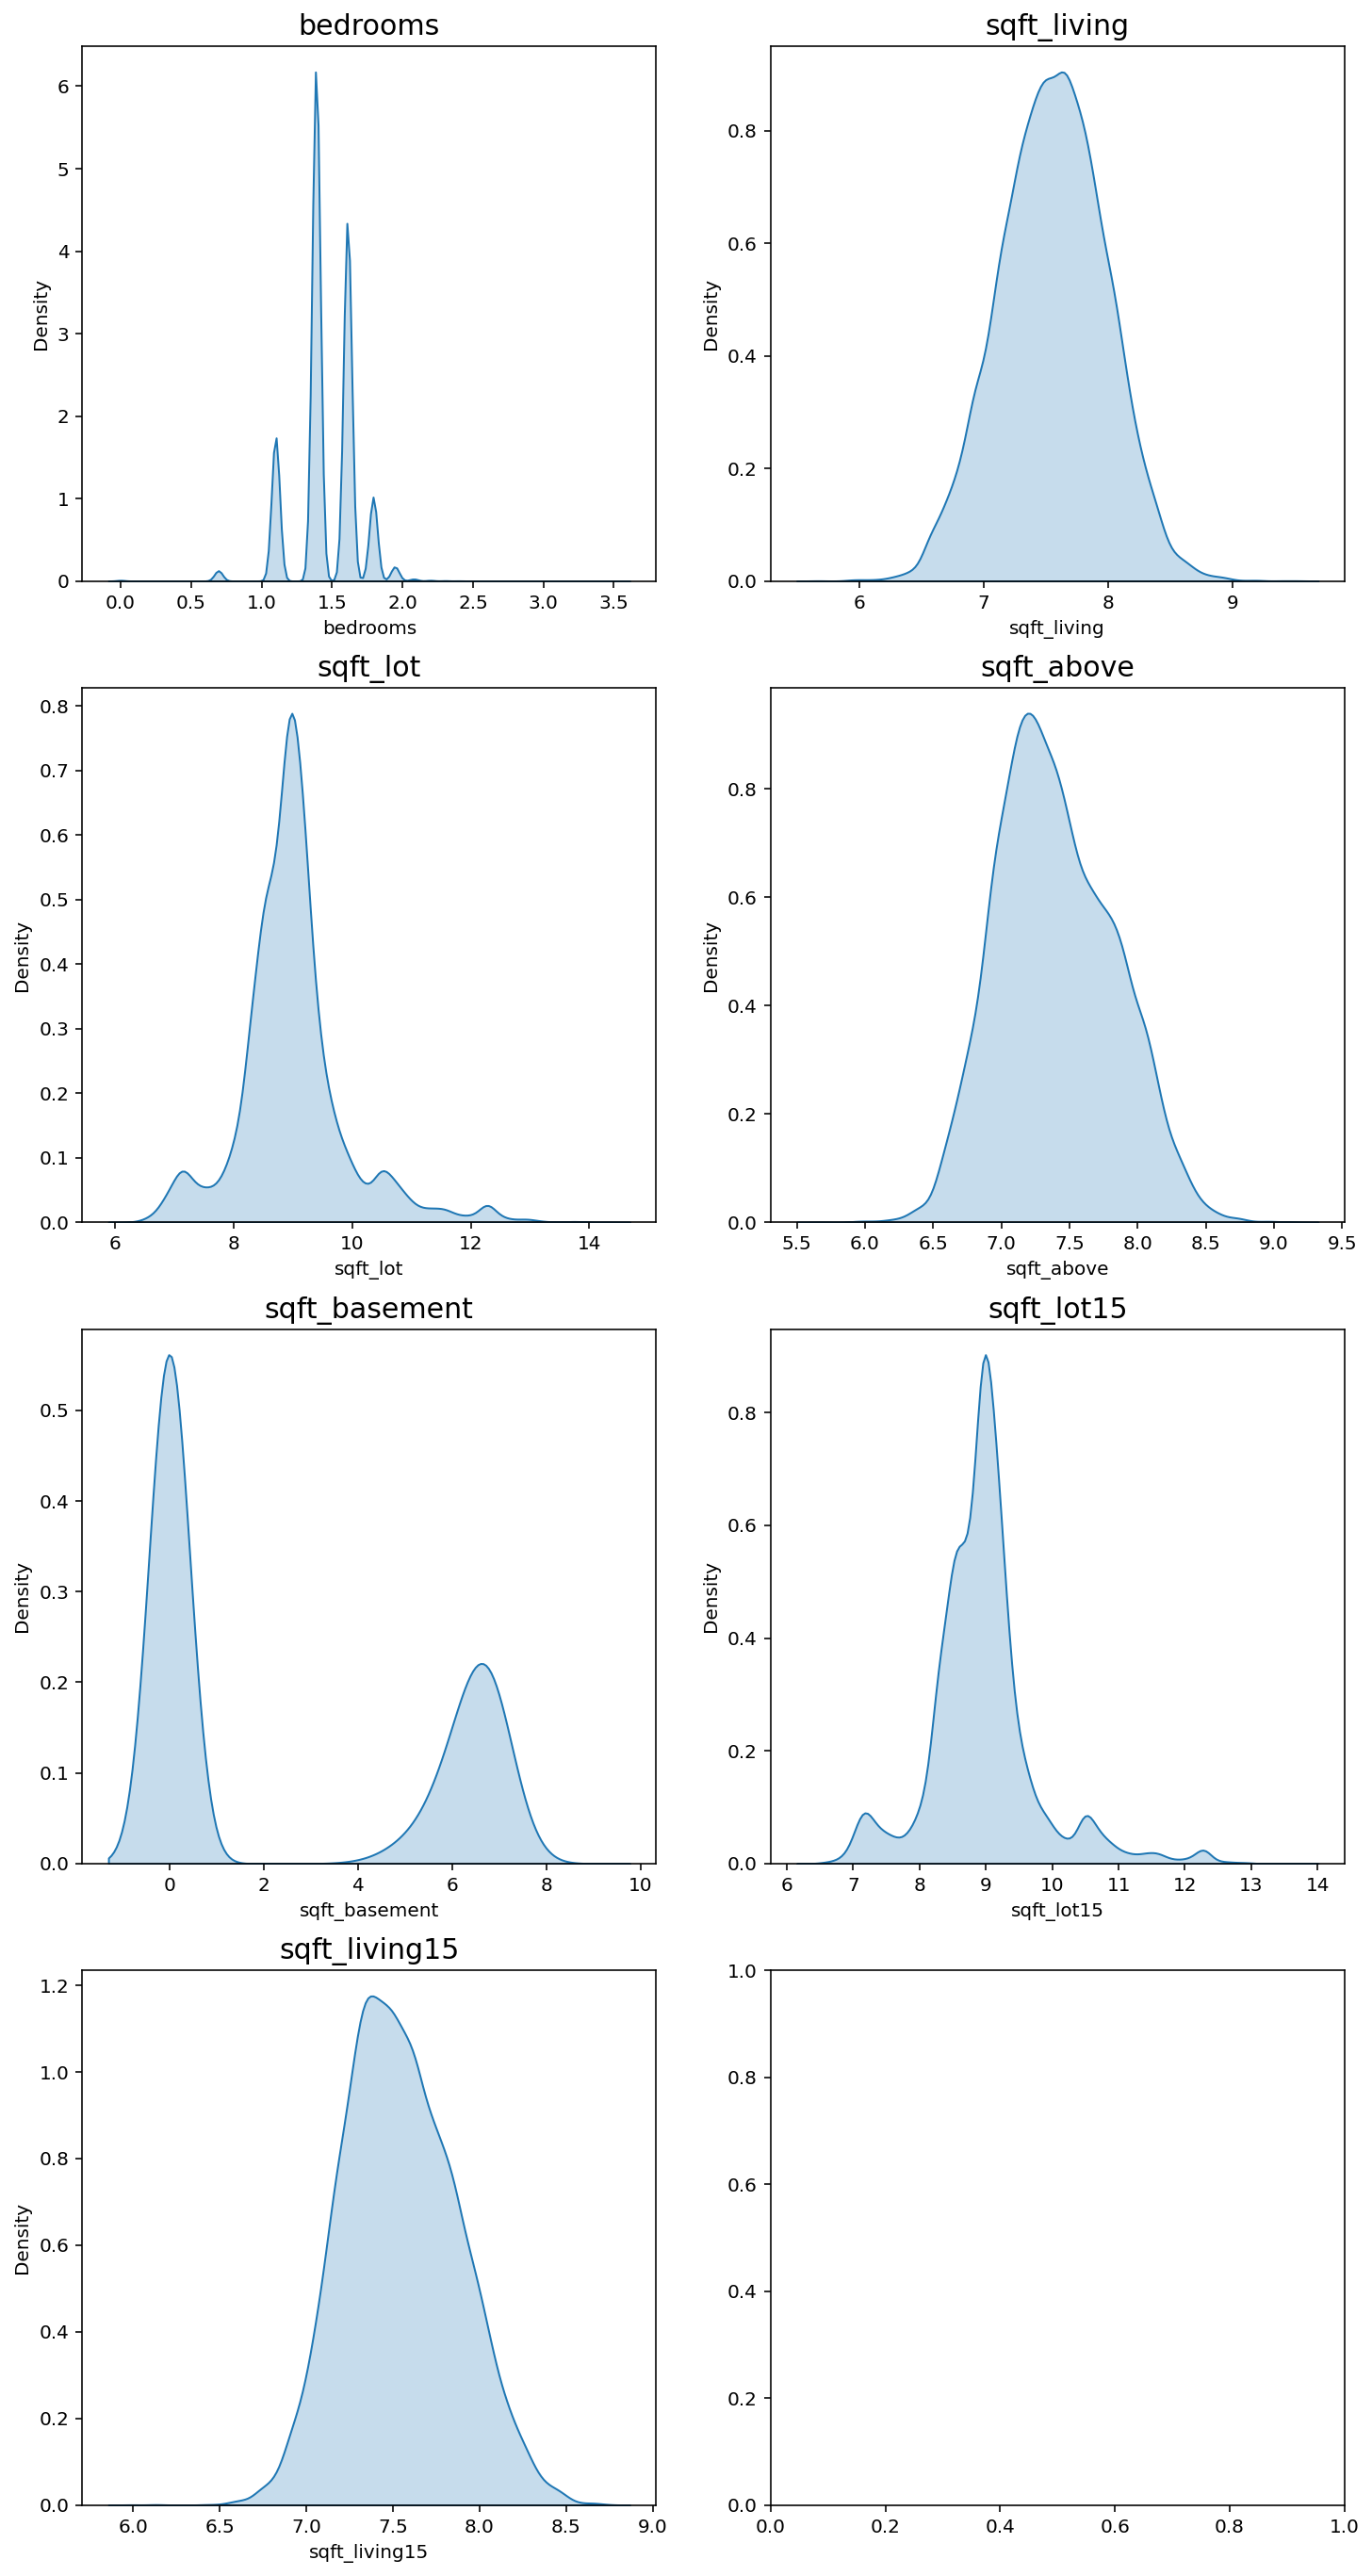

In [120]:
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(ax.shape[0]):
    for col in range(ax.shape[1]):
        if count == 7:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col], shade = True)
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

In [121]:
sub = data.iloc[train_len:, :] # Train, Test 합친 데이터셋 중 Test Set에 해당하는 데이터들 
x = data.iloc[:train_len, :]  #  Train, Test 합친 데이터셋 중 Train Set에 해당하는 데이터들 

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


# Average Blending

###### GBM

- Tabular format 데이터 (엑셀형태와 같이 X-Y Grid로 되어있는 데이터)에 대한 예측 성능이 훌륭
- Gradient를 통해 Boosting하는 알고리즘
- Boosting이란, 약한 분류기를 결합하여 강한 분류기를 만드는 과정 
- Boosting은 모델 A,B,C가 있다고 하면, 한번에 하는 것이 아니라, <br/>
  순차적으로 실행하고, 나온 결과값들을 모두 결합하여 최종 모델을 만든다
- Residual fitting 방법 
- 과적합이 일어날 수 있는 가능성 비교적 높아, regularization Technique이 더욱 필요

??? loss function이 줄어들기 위해 f(x)가 가려고하는 방향

시각화 http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html <br/>
https://3months.tistory.com/368

###### XGB and LGBM
GBM 많은 연산량을 해결하기 위해 효율적으로 구현한 패키지들

In [122]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)  
lightgbm = lgb.LGBMRegressor(random_state=2019) 

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

# Cross Validation

In [123]:
# DataFrame.values
x.values # data 변수 내 Column 별 값들 

array([['201410', 1.3862943611198906, 1.0, ..., -122.257,
        7.201170883281678, 8.639587799629844],
       ['201502', 1.0986122886681096, 1.0, ..., -122.233,
        7.908754738783246, 8.995040974685022],
       ['201502', 1.3862943611198906, 2.0, ..., -122.045,
        7.496097345175956, 8.92319149068606],
       ...,
       ['201405', 1.3862943611198906, 2.5, ..., -122.346,
        7.333676395657684, 7.31986492980897],
       ['201502', 1.6094379124341003, 2.5, ..., -122.362,
        7.5126175446745105, 8.881975184248867],
       ['201410', 1.0986122886681096, 0.75, ..., -122.299,
        6.928537818164665, 7.213768308118642]], dtype=object)

In [127]:
kfold = KFold(n_splits=5, shuffle= True, random_state=2019).get_n_splits(x.values)  

In [128]:
type(kfold)

int

In [129]:
kfold

5

###### cross_val_score 함수 사용법

https://guru.tistory.com/36

In [151]:
def get_cv_score(models): # model과 name을 키 값으로 가지는 dict들을 요소로 갖는 리스트
    kfold = KFold(n_splits=5, shuffle= True, random_state=2019).get_n_splits(x.values)  # sklearn.model_selection.KFold.get_n_splits : Returns the number of splitting iterations in the cross-validator
    for m in models:
        # cross_val_score returns
        # ndarray of float of shape=(len(list(cv)),)
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold)) # x.values : Train 데이터의 각 Column들의 값들  # y : 가격 정보
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}") # CV Score는 Grid Search의 cv_results_의 mean_test_score라고 생각하면 된다.

In [160]:
get_cv_score(models) # CV score는 일종의 Accuracy # Accuracy라면, 연속된 값인 Price에 대한 Accuray는 어떻게 측정되고 있는가? Accuracy 아님 
# 회귀 모델의 경우에 Cross_val_score 함수가 R^2를 반환한다. 
# R^2 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타낸다. 
# https://runebook.dev/ko/docs/scikit_learn/modules/generated/sklearn.metrics.r2_score

Model: GradientBoosting, CV score:0.8598
Model: XGBoost, CV score:0.8860
Model: LightGBM, CV score:0.8819


###### 각 수치의 의미
- GBM의 mean(평균)으로 그은 Black Line에 비해, GBM으로 그은 Blue Line 주변에 85.98퍼센트 더 적은 Variation이 있다.   
- XGB의 mean(평균)으로 그은 Black Line에 비해, XGB으로 그은 Blue Line 주변에 88.6퍼센트 더 적은 Variation이 있다.   
- LGBM의 mean(평균)으로 그은 Black Line에 비해, LGBM으로 그은 Blue Line 주변에 88.19퍼센트 더 적은 Variation이 있다.   

- 결론 : 위의 내용들은 결국, Train 데이터 사용한 Column들과 Price(집 값) 사이의 관계가 전체 Variance에서 해당 수치만큼 차지한다는 것을 의미한다

###### R squared Metric : Percentage of variation explained by the relationship between two variables

여기서 'R'은 'Correlation'을 뜻한다. 

- 왜 그냥 R을 사용하지 않고, Square을 해주는가?
'R'만 사용하는 것은 직관적이지 않다.
- ex. R = 0.7이 R = 0.5에 비해 두배 더 좋다는 것이 명확하게 와닿지 않는다. <br/> 반면, R^2 = 0.7 은 R^2 = 0.5에 비해 1.4배 더 좋다는 것이 잘 와닿는다. 
- 쉽고, 직관적이다. 

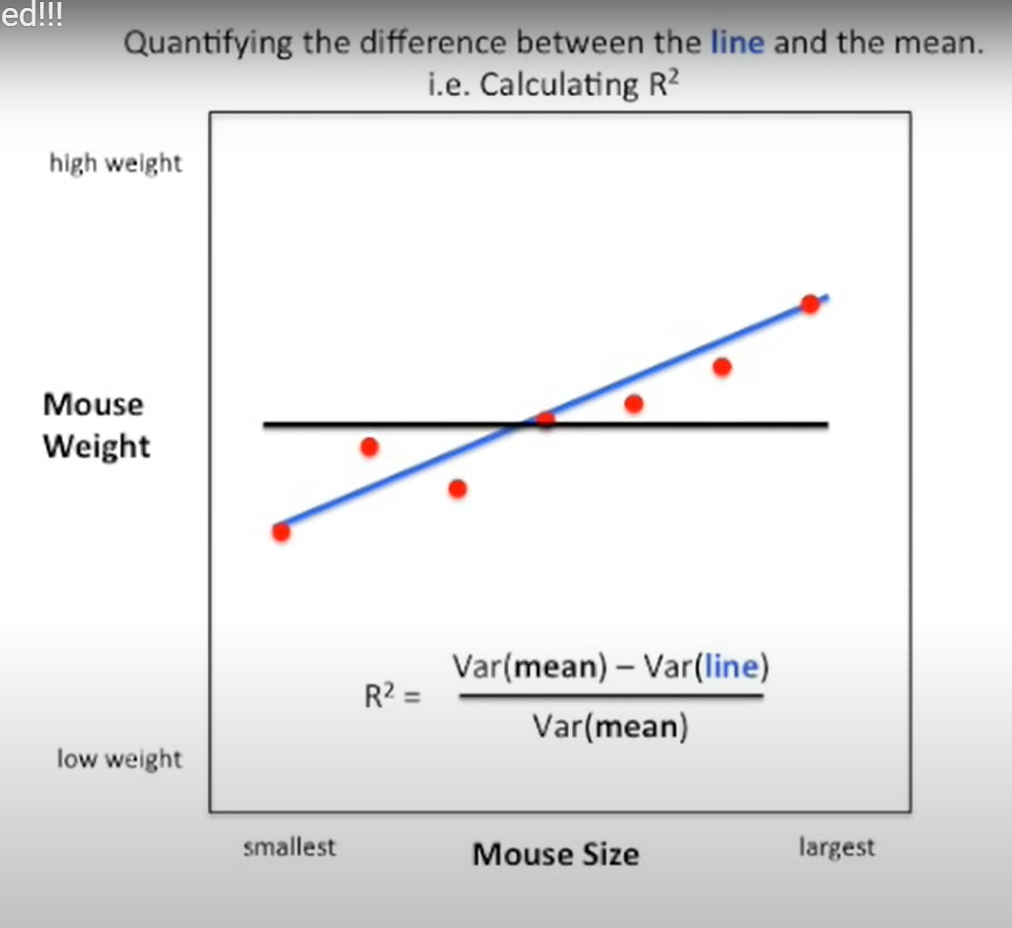

R^2 =  (Var(mean) - Var(blue line)) / Var(mean)

- Blue Line 주변의 Variation이 Black Line 주변의 Variation보다 클 수 없기 때문에, R^2 값의 범위는 1보다 클 수 없다. 

https://www.youtube.com/watch?v=2AQKmw14mHM

##### R^2 결정계수의 함정 

- 결정계수가 높으면 무조건 좋은 것인가? 그렇지는 않다
- 높은 R^2는 과적합 문제로부터 자유롭지 않다
- 결정계수를 확인하기 전에 잔차도(Residual Plot)이 랜덤하게 분포함을 확인해야 한다
- 의미 없는 독립변수의 추가 조차도 R^2를 약간이라도 증가시킨다
- 그러나 독립변수의 추가는 자유도를 1 증가시켜 비용이 발생한다
- 결론적으로, 추가된 독립변수가 자유도 1을 잃고도 충분히 분산을 설명했는지 여부가 중요하다
- 자유도를 감안한 결정계수(adj.R^2)가 필요하다

In [161]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    # predictions : 2차원 array
    predictions = np.column_stack([  # np.column_stack( ) : 1차원 배열을 가지고 와서, 열로 쌓는다.
        m['model'].predict(sub_x.values) for m in models # 모델 단위 sub_x에 대한 예측 값을, 각 모델들을 칼럼으로하여 쌓는다.
    ])
    return np.mean(predictions, axis=1) # models 개수만큼 나온 n개의 결과값들의 평균을 반환

####  AveragingBlending( ) 내부 확인용

In [162]:
for m in models : 
    m['model'].fit(x.values, y)

predictions = np.column_stack([  # np.column_stack( ) : 1차원 배열을 가지고 와서, 열로 쌓는다.
    m['model'].predict(sub.values) for m in models # 모델 단위 sub_x에 대한 예측 값을, 각 모델들을 칼럼으로하여 쌓는다.
])

print(predictions.shape)
predictions
#np.mean(predictions, axis=1) # models 개수만큼 나온 n개의 결과값들의 평균을 반환

(6468, 3)


array([[ 577619.72517056,  500527.1875    ,  511753.07647679],
       [ 363837.54418844,  494720.25      ,  433620.84399008],
       [1377862.26822824, 1410481.375     , 1296687.09405506],
       ...,
       [ 435501.3158619 ,  471353.25      ,  449390.50824845],
       [ 354036.89056832,  337087.75      ,  333594.29000994],
       [ 412866.375165  ,  436969.9375    ,  415339.05688549]])

In [163]:
sub

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15035,201412,1.386294,2.25,7.852050,8.887791,2.0,0,0,3,7,7.682943,5.993961,1951,1991,98125,47.7210,-122.319,7.433075,8.941153
15036,201412,1.609438,3.00,7.581210,8.517393,1.0,0,0,5,7,6.957497,6.814543,1965,0,98136,47.5208,-122.393,7.215975,8.517393
15037,201405,1.609438,4.50,8.598036,11.532051,1.0,0,0,3,11,8.266421,7.333676,2001,0,98053,47.6561,-122.005,8.468213,11.532051
15038,201504,1.386294,1.00,7.484930,8.918784,1.0,0,0,3,7,6.957497,6.594413,1960,0,98146,47.5123,-122.337,7.484930,9.001346
15039,201503,1.386294,2.50,7.544861,8.788898,2.0,0,0,3,7,7.544861,0.000000,2003,0,98038,47.3684,-122.031,7.779467,8.932080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21498,201406,1.386294,1.75,7.313887,9.390075,1.0,0,0,3,6,7.313887,0.000000,2014,0,98010,47.3095,-122.002,7.186144,9.332912
21499,201501,1.386294,2.00,7.307202,7.027315,3.0,0,0,3,8,7.307202,0.000000,2014,0,98144,47.5699,-122.288,7.244942,7.115582
21500,201502,1.386294,2.50,7.178545,7.166266,2.0,0,0,3,8,7.074117,4.875197,2008,0,98116,47.5773,-122.409,7.193686,7.143618
21501,201406,1.098612,0.75,6.928538,7.208600,2.0,0,0,3,7,6.928538,0.000000,2009,0,98144,47.5944,-122.299,6.928538,7.604894


In [164]:
y_pred = AveragingBlending(models, x, y, sub) # sub : Test 데이터셋
print(len(y_pred))
y_pred # 모델 별, 예측 값들의 평균 

6468


array([ 529966.66304912,  430726.21272617, 1361676.91242777, ...,
        452081.69137012,  341572.97685942,  421725.1231835 ])

In [42]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [43]:
result = pd.DataFrame({
    'id' : sub_id,  # Test 데이터셋의 'id'
    'price' : y_pred # Test 데이터셋에 대한 'price' 예측 값
})

result.head()

,id,price
0,15035,5.299667e+05
1,15036,4.307262e+05
2,15037,1.361677e+06
3,15038,3.338036e+05
4,15039,3.089006e+05


In [44]:
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission.csv


# 파라미터 튜닝

In [58]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [59]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [60]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [61]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [62]:
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [63]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


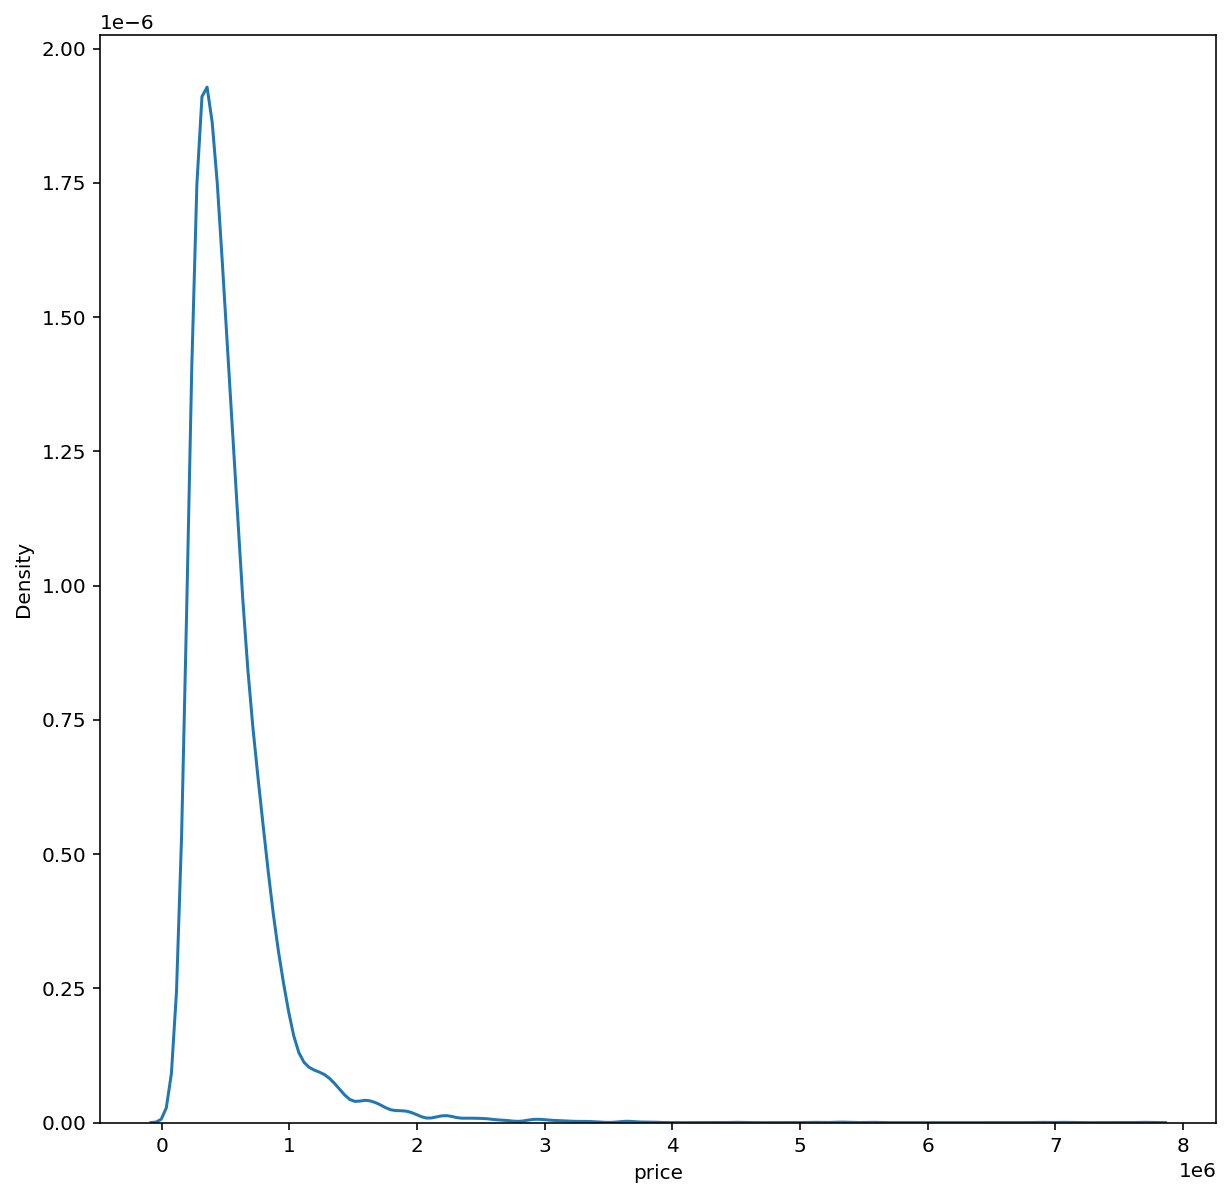

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))   
sns.kdeplot(y)
plt.show()

In [65]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

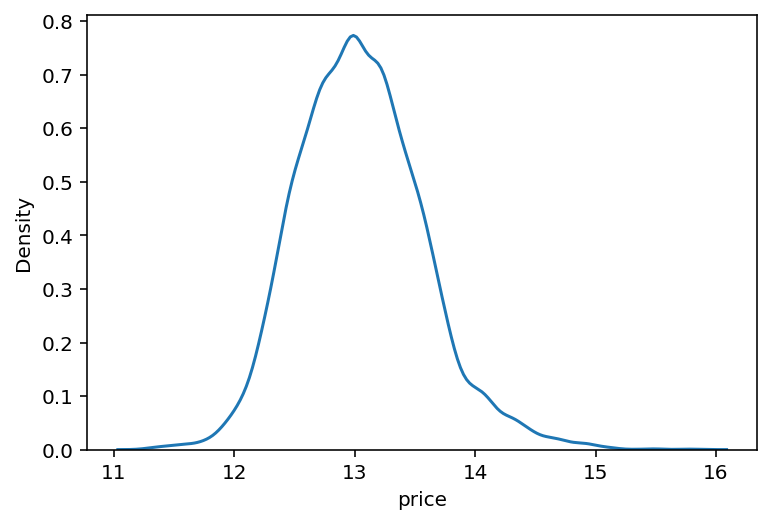

In [66]:
sns.kdeplot(y)
plt.show()

In [67]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

### 평가 척도 RMSE 

In [68]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred))) # MSE (mean_squared_error)

In [69]:
random_state=2020        

# Gradient Boosting # 미분을 통해서, Gradient를 찾는 과정
gboost = GradientBoostingRegressor(random_state=random_state) 
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

In [74]:
models = [gboost, xgboost, lightgbm, rdforest]

def get_scores(models, train, y):
    df = {}
    random_state = 27
    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__
        # train, test 데이터셋 분리
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

        # 모델 학습
        model.fit(X_train, y_train)

        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)

        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    return score_df
get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,132370.054687
RandomForestRegressor,126433.242489
XGBRegressor,118423.791779
LGBMRegressor,111384.338819


In [75]:
models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}, {'model':rdforest, 'name':'RandomForestRegressor'}]

### 4가지 모델을 바탕으로 하는 Average Blending 

In [76]:
y_pred = AveragingBlending(models, x, y, sub) # sub : Test 데이터셋
print(len(y_pred))
y_pred # 모델 별, 예측 값들의 평균 

6468


array([13.12155829, 13.02047159, 14.07489914, ..., 13.03144944,
       12.71654465, 12.99392785])

In [77]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [78]:
result = pd.DataFrame({
    'id' : sub_id,  # Test 데이터셋의 'id'
    'price' : y_pred # Test 데이터셋에 대한 'price' 예측 값
})

result.head()

,id,price
0,15035,13.121558
1,15036,13.020472
2,15037,14.074899
3,15038,12.623848
4,15039,12.676442


In [79]:
# Public Score 12000점 
my_submission_path = join(data_dir, '4_Avg.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/4_Avg.csv


# LGBM 관련 하이퍼 파라미터

In [169]:
param_grid = {
    'n_estimators': [20, 40, 60, 80, 100], # 생성할 Tree의 개수 
    'max_depth': [10, 15, 20]     # Tree의 최대 깊이 
}

In [170]:
model = LGBMRegressor(random_state= 2019)

print('얍💢')

얍💢


In [175]:
# scoring : Classification, Clustering, Regression에 따라 서로 다른 Scoring 방법을 사용
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring= 'neg_mean_squared_error',\
                        cv=5, verbose=1, n_jobs=5)


# grid_model.fit(x ,y) 때는 Value Error 발생한다
grid_model.fit(x.values, y) 

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2019), n_jobs=5,
             param_grid={'max_depth': [10, 15, 20],
                         'n_estimators': [20, 40, 60, 80, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [177]:
grid_model.cv_results_ 

{'mean_fit_time': array([0.17765117, 0.28755136, 0.45640941, 0.53450484, 0.7397275 ,
        0.17985158, 0.32630243, 0.43264995, 0.63665981, 0.62018785,
        0.23382139, 0.29680524, 0.49800334, 0.56706529, 0.5734261 ]),
 'std_fit_time': array([0.03148153, 0.03792381, 0.09645718, 0.12468778, 0.19447936,
        0.00629632, 0.06009069, 0.04697202, 0.09700315, 0.106523  ,
        0.06224107, 0.04705012, 0.17477111, 0.10756139, 0.18306201]),
 'mean_score_time': array([0.009552  , 0.02006211, 0.03173528, 0.03555217, 0.06110115,
        0.00923166, 0.02046409, 0.02778535, 0.05313358, 0.05252128,
        0.00988402, 0.03164978, 0.04046459, 0.04009552, 0.03167057]),
 'std_score_time': array([0.00068209, 0.00977089, 0.01360165, 0.01137256, 0.0282559 ,
        0.00085502, 0.00973752, 0.0067401 , 0.01605439, 0.02050594,
        0.00038953, 0.0136303 , 0.01611931, 0.0211745 , 0.00819703]),
 'param_max_depth': masked_array(data=[10, 10, 10, 10, 10, 15, 15, 15, 15, 15, 20, 20, 20, 20,
           

In [178]:
# mean_test_score : average of columns split_0_test_score, split_1_test_score, split_2_test_score ,....
# std_test_score : standard deviation of split_0_test_score, split_1_test_score, split_2_test_score, ...
# split0_test_score : 어레이 type : 각각의 값은 파라미터 조합에 따른 해당 fold의 est Score 
pd.DataFrame(grid_model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.177651,0.031482,0.009552,0.000682,10,20,"{'max_depth': 10, 'n_estimators': 20}",-3.056621e+10,-2.778796e+10,-2.246950e+10,-1.956176e+10,-2.030959e+10,-2.413901e+10,4.313391e+09,15
1,0.287551,0.037924,0.020062,0.009771,10,40,"{'max_depth': 10, 'n_estimators': 40}",-2.221247e+10,-2.090023e+10,-1.629078e+10,-1.605047e+10,-1.452866e+10,-1.799652e+10,2.997614e+09,10
2,0.456409,0.096457,0.031735,0.013602,10,60,"{'max_depth': 10, 'n_estimators': 60}",-2.076214e+10,-1.938562e+10,-1.514200e+10,-1.573314e+10,-1.332717e+10,-1.687001e+10,2.767930e+09,7
3,0.534505,0.124688,0.035552,0.011373,10,80,"{'max_depth': 10, 'n_estimators': 80}",-2.041694e+10,-1.879348e+10,-1.484459e+10,-1.559828e+10,-1.310890e+10,-1.655244e+10,2.669900e+09,5
4,0.739727,0.194479,0.061101,0.028256,10,100,"{'max_depth': 10, 'n_estimators': 100}",-1.999482e+10,-1.835703e+10,-1.481127e+10,-1.571360e+10,-1.294427e+10,-1.636420e+10,2.517282e+09,3
5,0.179852,0.006296,0.009232,0.000855,15,20,"{'max_depth': 15, 'n_estimators': 20}",-3.057397e+10,-2.787489e+10,-2.234371e+10,-1.962899e+10,-2.004753e+10,-2.409382e+10,4.373988e+09,13
6,0.326302,0.060091,0.020464,0.009738,15,40,"{'max_depth': 15, 'n_estimators': 40}",-2.215521e+10,-2.130572e+10,-1.619072e+10,-1.582589e+10,-1.479853e+10,-1.805521e+10,3.047229e+09,12
7,0.432650,0.046972,0.027785,0.006740,15,60,"{'max_depth': 15, 'n_estimators': 60}",-2.095726e+10,-1.978257e+10,-1.504696e+10,-1.532576e+10,-1.347060e+10,-1.691663e+10,2.913483e+09,9
8,0.636660,0.097003,0.053134,0.016054,15,80,"{'max_depth': 15, 'n_estimators': 80}",-2.042686e+10,-1.907680e+10,-1.463205e+10,-1.514837e+10,-1.330076e+10,-1.651697e+10,2.742623e+09,4
9,0.620188,0.106523,0.052521,0.020506,15,100,"{'max_depth': 15, 'n_estimators': 100}",-2.027842e+10,-1.875156e+10,-1.452877e+10,-1.524076e+10,-1.302122e+10,-1.636414e+10,2.713929e+09,2


In [179]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 10, 'n_estimators': 20},
 {'max_depth': 10, 'n_estimators': 40},
 {'max_depth': 10, 'n_estimators': 60},
 {'max_depth': 10, 'n_estimators': 80},
 {'max_depth': 10, 'n_estimators': 100},
 {'max_depth': 15, 'n_estimators': 20},
 {'max_depth': 15, 'n_estimators': 40},
 {'max_depth': 15, 'n_estimators': 60},
 {'max_depth': 15, 'n_estimators': 80},
 {'max_depth': 15, 'n_estimators': 100},
 {'max_depth': 20, 'n_estimators': 20},
 {'max_depth': 20, 'n_estimators': 40},
 {'max_depth': 20, 'n_estimators': 60},
 {'max_depth': 20, 'n_estimators': 80},
 {'max_depth': 20, 'n_estimators': 100}]

In [180]:
score = grid_model.cv_results_['mean_test_score']
score

array([-2.41390053e+10, -1.79965213e+10, -1.68700124e+10, -1.65524369e+10,
       -1.63641957e+10, -2.40938160e+10, -1.80552140e+10, -1.69166296e+10,
       -1.65169688e+10, -1.63641437e+10, -2.40938160e+10, -1.80430136e+10,
       -1.69052413e+10, -1.65665598e+10, -1.63240338e+10])

In [181]:
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,10,20,-2.413901e+10
1,10,40,-1.799652e+10
2,10,60,-1.687001e+10
3,10,80,-1.655244e+10
4,10,100,-1.636420e+10
5,15,20,-2.409382e+10
6,15,40,-1.805521e+10
7,15,60,-1.691663e+10
8,15,80,-1.651697e+10
9,15,100,-1.636414e+10


In [182]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,10,20,-2.413901e+10,155367.323730
1,10,40,-1.799652e+10,134151.113696
2,10,60,-1.687001e+10,129884.611760
3,10,80,-1.655244e+10,128656.274066
4,10,100,-1.636420e+10,127922.615898
5,15,20,-2.409382e+10,155221.828214
6,15,40,-1.805521e+10,134369.691640
7,15,60,-1.691663e+10,130063.944242
8,15,80,-1.651697e+10,128518.359743
9,15,100,-1.636414e+10,127922.412675


In [183]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,10,20,-2.413901e+10,155367.323730
1,10,40,-1.799652e+10,134151.113696
2,10,60,-1.687001e+10,129884.611760
3,10,80,-1.655244e+10,128656.274066
4,10,100,-1.636420e+10,127922.615898
5,15,20,-2.409382e+10,155221.828214
6,15,40,-1.805521e+10,134369.691640
7,15,60,-1.691663e+10,130063.944242
8,15,80,-1.651697e+10,128518.359743
9,15,100,-1.636414e+10,127922.412675


In [184]:
results.sort_values('RMSLE', ascending = True)

,max_depth,n_estimators,score,RMSLE
14,20,100,-1.632403e+10,127765.542176
9,15,100,-1.636414e+10,127922.412675
4,10,100,-1.636420e+10,127922.615898
8,15,80,-1.651697e+10,128518.359743
3,10,80,-1.655244e+10,128656.274066
13,20,80,-1.656656e+10,128711.148605
2,10,60,-1.687001e+10,129884.611760
12,20,60,-1.690524e+10,130020.157411
7,15,60,-1.691663e+10,130063.944242
1,10,40,-1.799652e+10,134151.113696


# 일반화

In [200]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5): 
    grid_model = GridSearchCV(model, param_grid=param_grid, \
                            scoring='neg_mean_squared_error', \
                            cv=5, verbose= verbose, n_jobs=5)
    grid_model.fit(train, y)
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    results = pd.DataFrame(params)
    results['score'] = score
    results['RMSE'] = np.sqrt(-1 * results['score'])
    return results

In [201]:
param_grid = {
    'n_estimators': [20,40,60,80,100],
    'max_depth': [5, 10, 15, 20],
    'learning_rate': [0.05,0.1,0.15,0.2],
    'num_iterations':[1000,2000],
    
}
# 니중에 확인할 것 
# Boosting Type이 'rf'이면, Score가 NaN으로 나오네?
# 그렇다는 것은 Mean Test Score가 NaN이라는 것인데...

model = LGBMRegressor(random_state=2019)
myResults= my_GridSearch(model, x.values, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[CV] END learning_rate=0.05, max_depth=5, n_estimators=20, num_iterations=1000; total time=   3.2s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=20, num_iterations=2000; total time=   6.5s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=40, num_iterations=1000; total time=   3.4s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=40, num_iterations=1000; total time=   3.6s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=40, num_iterations=2000; total time=   6.8s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=60, num_iterations=1000; total time=   3.3s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=60, num_iterations=2000; total time=   6.4s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=80, num_iterations=1000; total time=   4.2s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=80, num_iterations=1000; total time=   3.3s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=80, num_iterations=2000; total time=   6.5s
[CV] END l

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.05, max_depth=5, n_estimators=20, num_iterations=1000; total time=   6.5s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=20, num_iterations=2000; total time=   7.6s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=40, num_iterations=1000; total time=   5.3s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=40, num_iterations=2000; total time=   9.8s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=60, num_iterations=2000; total time=   7.8s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=80, num_iterations=1000; total time=   4.7s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=80, num_iterations=2000; total time=   6.7s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=100, num_iterations=1000; total time=   3.3s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=100, num_iterations=2000; total time=   7.8s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=20, num_iterations=1000; total time=   4.9s
[CV] EN

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[CV] END learning_rate=0.05, max_depth=5, n_estimators=20, num_iterations=1000; total time=   4.7s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=20, num_iterations=2000; total time=  11.0s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=40, num_iterations=2000; total time=   8.2s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=60, num_iterations=1000; total time=   4.8s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=60, num_iterations=2000; total time=   8.3s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=80, num_iterations=1000; total time=   5.3s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=80, num_iterations=2000; total time=  10.7s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=100, num_iterations=2000; total time=   7.2s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=20, num_iterations=1000; total time=   8.2s
[CV] END learning_rate=0.05, max_depth=10, n_estimators=20, num_iterations=2000; total time=  11.0s
[CV] EN

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[CV] END learning_rate=0.05, max_depth=5, n_estimators=20, num_iterations=1000; total time=   3.4s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=20, num_iterations=2000; total time=   8.2s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=40, num_iterations=1000; total time=   3.9s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=40, num_iterations=2000; total time=   8.1s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=60, num_iterations=1000; total time=   4.4s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=60, num_iterations=2000; total time=   8.2s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=80, num_iterations=1000; total time=   4.1s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=80, num_iterations=2000; total time=   9.7s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=100, num_iterations=1000; total time=   3.4s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=100, num_iterations=2000; total time=   8.6s
[CV] END

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[CV] END learning_rate=0.05, max_depth=5, n_estimators=20, num_iterations=1000; total time=   3.5s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=20, num_iterations=2000; total time=   7.8s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=40, num_iterations=1000; total time=   3.4s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=40, num_iterations=2000; total time=   6.3s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=60, num_iterations=1000; total time=   3.2s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=60, num_iterations=1000; total time=   3.9s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=60, num_iterations=2000; total time=  10.7s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=80, num_iterations=2000; total time=   6.7s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=100, num_iterations=1000; total time=   4.4s
[CV] END learning_rate=0.05, max_depth=5, n_estimators=100, num_iterations=1000; total time=   3.9s
[CV] END

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

In [202]:
myResults.head()

,learning_rate,max_depth,n_estimators,num_iterations,score,RMSE
0,0.05,5,20,1000,-1.511554e+10,122945.265484
1,0.05,5,20,2000,-1.494534e+10,122251.124072
2,0.05,5,40,1000,-1.511554e+10,122945.265484
3,0.05,5,40,2000,-1.494534e+10,122251.124072
4,0.05,5,60,1000,-1.511554e+10,122945.265484


In [203]:
myResults.sort_values('RMSE')

,learning_rate,max_depth,n_estimators,num_iterations,score,RMSE
1,0.05,5,20,2000,-1.494534e+10,122251.124072
3,0.05,5,40,2000,-1.494534e+10,122251.124072
5,0.05,5,60,2000,-1.494534e+10,122251.124072
7,0.05,5,80,2000,-1.494534e+10,122251.124072
9,0.05,5,100,2000,-1.494534e+10,122251.124072
...,...,...,...,...,...,...
153,0.20,20,40,2000,-1.730497e+10,131548.347825
151,0.20,20,20,2000,-1.730497e+10,131548.347825
155,0.20,20,60,2000,-1.730497e+10,131548.347825
157,0.20,20,80,2000,-1.730497e+10,131548.347825


### Gride Search 결과 

다음과 같은 하이퍼 파라미터 값이 최적의 결과를 산출해냈다.
- max_depth = 10
- n_estimators = 50
- learning_rate = 0.05
- num_iterations = 1000

In [204]:
model_LGB = LGBMRegressor(max_depth=10, n_estimators=50,learning_rate=0.05,num_iterations=1000, boosting_type = 'gbdt', random_state=random_state)
model_LGB.fit(train, y)
prediction_LGB = model_LGB.predict(sub)
prediction_LGB

NameError: name 'random_state' is not defined

In [ ]:
prediction_LGB = np.expm1(prediction_LGB)
prediction_LGB

In [ ]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

In [ ]:
submission['price'] = prediction_LGB
submission.head()

In [ ]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.161028')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

In [ ]:
# 일반화 함수
def save_submission(model, train, y, test, model_name, rmsle):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print(submission_csv_path)

In [ ]:
save_submission(model_LGB, train, y, test, 'lgbm', rmsle='0.161028')

시간 문제로 LGBM만 제출해보았는데, 퍼블릭 스코어는 114741으로 110000 이하 점수 달성에는 실패하였으나, 
추후 시간을 활용하여 다른 Regressor들을 활용하여 점수를 높이고 싶다

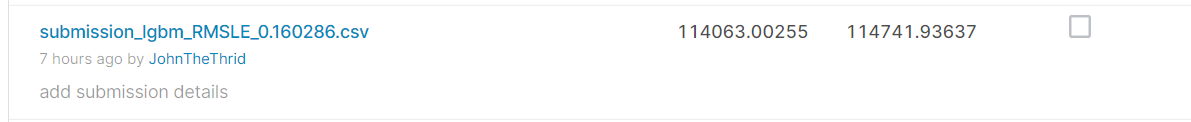

# gboost 관련 파라미터

In [ ]:
param_grid = {
    'n_estimators': [20,40,60,80,100],
    'max_depth': np.linspace(10,100,10),
    'learning_rate': [0.1,0.15,0.2],
}

model_GBM = GradientBoostingRegressor(random_state=2019)
myResults_GBM= my_GridSearch(model_GBM, x.values, y, param_grid, verbose=2, n_jobs=5)

In [ ]:
myResults_GBM.head()

In [ ]:
myResults_GBM.sort_values('RMSE')

### Gride Search 결과 

다음과 같은 하이퍼 파라미터 값이 최적의 결과를 산출해냈다.
- max_depth = 
- n_estimators = 
- learning_rate = 

In [ ]:
model = LGBMRegressor(max_depth=10, n_estimators=50,learning_rate=0.05,num_iterations=1000, boosting_type = 'gbdt', random_state= 2019)
model.fit(x.values, y)
prediction = model.predict(sub)
prediction

In [ ]:
prediction = np.expm1(prediction)
prediction

In [ ]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

In [ ]:
submission['price'] = prediction
submission.head()

In [ ]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.161028')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

In [ ]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.161028')

# XGB 관련 파라미터

In [ ]:
param_grid = {
    'n_estimators': [10,20,30],
    'max_depth': np.linspace(10,100,10),
    'learning_rate': [0.1,0.15,0.2],
}

model_XGB = XGBRegressor(random_state= 2019)
myResults_XGB= my_GridSearch(model_XGB, x.values, y, param_grid, verbose=2, n_jobs=5)

In [ ]:
myResults_XGB.head()

In [ ]:
myResults_XGB.sort_values('RMSE')

### Gride Search 결과 

다음과 같은 하이퍼 파라미터 값이 최적의 결과를 산출해냈다.
- max_depth = 
- n_estimators = 
- learning_rate = 

In [ ]:
model_XGB  = XGBRegressor(max_depth=10, n_estimators=50,learning_rate=0.05,num_iterations=1000, boosting_type = 'gbdt', random_state=random_state)
model_XGB.fit(x.values, y)
prediction_XGB = model.predict(sub)
prediction_XGB

In [ ]:
prediction_XGB = np.expm1(prediction_XGB)
prediction_XGB

In [ ]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

In [ ]:
submission['price'] = prediction_XGB
submission.head()

In [ ]:
save_submission(model_XGB, x.values, y, test, 'XGB', rmsle='1234')

# RandomForest 관련 파라미터

In [ ]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': np.linspace(10,100,10),
    'learning_rate': np.linspace(0.0001, 0.1, 20),
    'num_iterations':[1000,2000],
    
}

model_RF = RandomForestRegressor(random_state= 2019)
myResults_RF= my_GridSearch(model_RF, x.values, y, param_grid, verbose=2, n_jobs=5)

In [ ]:
myResults_RF.head()

In [ ]:
myResults_RF.sort_values('RMSE')

### Gride Search 결과 

다음과 같은 하이퍼 파라미터 값이 최적의 결과를 산출해냈다.
- max_depth = 
- n_estimators = 
- learning_rate = 

In [ ]:
model_RF  = RandomForestRegressor(max_depth=10, n_estimators=50,learning_rate=0.05,num_iterations=1000, boosting_type = 'gbdt', random_state=random_state)
model_RF.fit(x.values, y)
prediction_RF= model_RF.predict(sub)
prediction_RF

In [ ]:
prediction_RF = np.expm1(prediction_RF)
prediction_RF

In [ ]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

In [ ]:
submission['price'] = prediction_RF
submission.head()

In [ ]:
save_submission(model_RF, x.values, y, test, 'RF', rmsle='')

# 튜닝된 Regressor 활용한 Avegrage Blending

In [ ]:
models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [ ]:
y_pred = AveragingBlending(models, x, y, sub) 

In [ ]:
y_pred = AveragingBlending(models, x, y, sub) # sub : Test 데이터셋
print(len(y_pred))
y_pred # 모델 별, 예측 값들의 평균 

In [ ]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

In [ ]:
result = pd.DataFrame({
    'id' : sub_id,  # Test 데이터셋의 'id'
    'price' : y_pred # Test 데이터셋에 대한 'price' 예측 값
})

result.head()

In [ ]:
# Public Score 12000점 
my_submission_path = join(data_dir, '4_Avg.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

In [ ]:
y_pred = AveragingBlending(models, x, y, sub) # sub : Test 데이터셋
print(len(y_pred))
y_pred # 모델 별, 예측 값들의 평균 

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

result = pd.DataFrame({
    'id' : sub_id,  # Test 데이터셋의 'id'
    'price' : y_pred # Test 데이터셋에 대한 'price' 예측 값
})

result.head()

# Public Score 12000점 
my_submission_path = join(data_dir, '4_Avg.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)